# logsumexp experiments

In [1]:
import torch

In [2]:
from blase.telluric import TelluricModel

In [3]:
model = TelluricModel()

In [4]:
model

TelluricModel()

In [5]:
dat = model.get_hapi_molec_data("H2O")

In [6]:
dat['nu'].shape

torch.Size([70039])

In [7]:
dat.keys()

odict_keys(['n_air', 'gamma_air', 'gamma_self', 'elower', 'gpp', 'nu', 'delta_air', 'sw'])

In [8]:
%%time
q_orig = model.tips_Q_of_T(310.0, dat['gpp'], dat['elower'])

CPU times: user 935 µs, sys: 155 µs, total: 1.09 ms
Wall time: 799 µs


In [9]:
q_orig, torch.log(q_orig)

(tensor(37777.8846, device='cuda:0', dtype=torch.float64),
 tensor(10.5395, device='cuda:0', dtype=torch.float64))

In [10]:
dat['gpp'].min(), dat['gpp'].max()

(tensor(1., device='cuda:0', dtype=torch.float64),
 tensor(141., device='cuda:0', dtype=torch.float64))

The Partition Function is:  

$$Q(T) = \sum_k g_k \exp\left(-\frac{c_2E_k}{T}\right)$$


Can we rewrite this in terms of logsumexp?


$$Q(T) = \sum_k \exp\big(\log(g_k)\big) \cdot \exp\left(-\frac{c_2E_k}{T}\right)$$

which is:

$$Q(T) = \sum_k  \exp\left(-\frac{c_2E_k}{T} + \log(g_k) \right)$$

In [11]:
log_q = torch.logsumexp(-model.hitran_c2*dat['elower']/310.0 + torch.log(dat['gpp']), 0)

In [12]:
torch.exp(log_q)

tensor(37777.8846, device='cuda:0', dtype=torch.float64)

In [13]:
print(torch.log(q_orig).item(), log_q.item())

10.53947914591812 10.53947914591812


Same answer, checks out.

In [14]:
torch.isfinite(dat['nu']).all().item()

True

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [16]:
sns.set_style('dark')

In [17]:
import astropy.units as u

In [18]:
wls = np.linspace(12600, 12800, 20000)
nus = torch.tensor(
    (wls * u.Angstrom).to(1 / u.cm, equivalencies=u.spectral()).value,
    device=model.device,
)
mask = (dat["nu"] > nus.min()) & (dat["nu"] < nus.max())
for key in dat.keys():
    dat[key] = dat[key][mask]

In [19]:
trans = model.transmission_of_T_p(290.0, 0.99, nus, 0.21, dat)

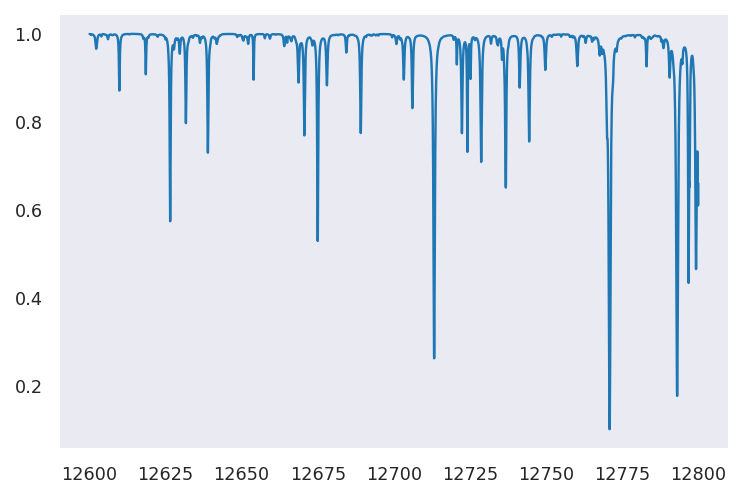

In [20]:
plt.plot(wls, trans.cpu())